# COSC2673 - Machine Learning - Assignment 2
### Authors: Louise Platts (S3908818) & Samuel Macintyre (S3888492)

# Classifying Images of Road Traffic Signs

# Introduction

* want to solve two problems 
    - classifying road signs according to sign-shape
    - classifying road signs according to sign-type
* utilises the modified Belgium Traffic Sign Classification Benchmark dataset (as preprepared for this assignment and provided on Canvas)
* problems will be solved via investigations of supervised machine learning algorithms for each of the two problems
* a final independent evaluation will also take place which will involve using the trained models on independently collected data and evaluating performance

#### More about the dataset
* 28x28 gray-scale images 
* possible sign-shapes
    - diamond
    - hex 
    - round 
    - square
    - triangle
* possible sign-types
    - right of way
    - stop
    - bicycle
    - limited traffic
    - no entry
    - no parking
    - roundabout
    - speed
    - traffic directive
    - travel direction
    - continue
    - crossing
    - lane end
    - parking
    - giveway
    - warning


#### CRISP-DM Process 
Our investigation and solution to the problem is guided by the Cross Industry Standard Process for Data Mining (CRISP-DM) process.  Kelleher, Namee and D'Arcy (2015) describe this process as containing key phases which have been modified to suit our problem and will be addressed as follows:
* Data Understanding - examining the data structure, and for our case the file structure as this contains the relevant label for each data point 
* Data Preparation - examining required inputs of machine learning algorithms and models and transforming to suit
* Modelling - apply machine learning algorithms and models to investigate the application and performance of models, and attempt to improve performance via tuning 
* Evaluation - generating performance metrics for models generated, and using this to guide further tuning and improvement of models, finding the ultimate best model type and parameter choice for the problem to solve
* Deployment - using the ultimate model found for each problem and applying it to independent data to implement the model in a real-world situation

#### Libraries Required

* what libraries are available for image classification supervised ml 
* why we made decisions we did - e.g. tensorflow because taught and requested by teacing team ?? [probs not this but lol we have been told] etc. 

In [81]:
# import statements
    
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import glob
from PIL import Image
import zipfile

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split



In [91]:
# import statements from resnet notebook
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

c:\Users\SJMac\anaconda3\envs\pds\lib\site-packages\keras\backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


# Data Understanding & Data Preparation

In [62]:
def image_reader(path):
    image_list = []
    for filepath in glob.glob(path, recursive=True):
        shape = filepath.split("\\")[-3]
        type = filepath.split("\\")[-2]
        filename = filepath.split("\\")[-1]
        label = filename.split(".")[0]
        
        image_list.append({"filepath": filepath,'filename':filename,'label':label,'shape':shape,'type':type})

    dataset = pd.DataFrame(image_list)

    return dataset

def drop_unused_target(train, val, col):
    train1 = train.copy()
    val1 = val.copy()

    train1 = train1.drop(col,axis=1)
    val1 = val1.drop(col,axis=1)
    return train1, val1

In [85]:
raw_data = image_reader("./trafficsigns_dataset/*/*/*.png")
# raw_data.head()

# Split data into train and test
train_data, val_data = train_test_split(raw_data, test_size=0.2, random_state=42)

TOTAL_SHAPES = raw_data['shape'].nunique()
TOTAL_TYPES = raw_data['type'].nunique()

SHAPE_NAMES = raw_data['shape'].unique()
TYPE_NAMES = raw_data['type'].unique()

print(f"Train data : {train_data.shape[0]}, Val Data: {val_data.shape[0]}")
print(f"Shape Classes:{SHAPE_NAMES}")
print(f"Type Classes: {TYPE_NAMES}")
print(f"Num Shape Classes: {TOTAL_SHAPES}, Num Type Classes: {TOTAL_TYPES}")


# Split training and validation into frames for respective classification type
shape_train_data, shape_val_data = drop_unused_target(train_data, val_data, "type")
type_train_data, type_val_data = drop_unused_target(train_data, val_data, "shape")


Train data : 2959, Val Data: 740
Shape Classes:['diamond' 'hex' 'round' 'square' 'triangle']
Type Classes: ['rightofway' 'stop' 'bicycle' 'limitedtraffic' 'noentry' 'noparking'
 'roundabout' 'speed' 'trafficdirective' 'traveldirection' 'continue'
 'crossing' 'laneend' 'parking' 'giveway' 'warning']
Num Shape Classes: 5, Num Type Classes: 16


In [158]:
def make_subplot(x,data,ax,order,title):
    fontsize = 12
    sns.countplot(x=x,data=data, order=order, ax=ax)
    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel(x, fontsize=fontsize)
    ax.set_ylabel("Count", fontsize=fontsize)
    ax.tick_params(labelsize=fontsize)
    ax.tick_params(axis="x",rotation=90)


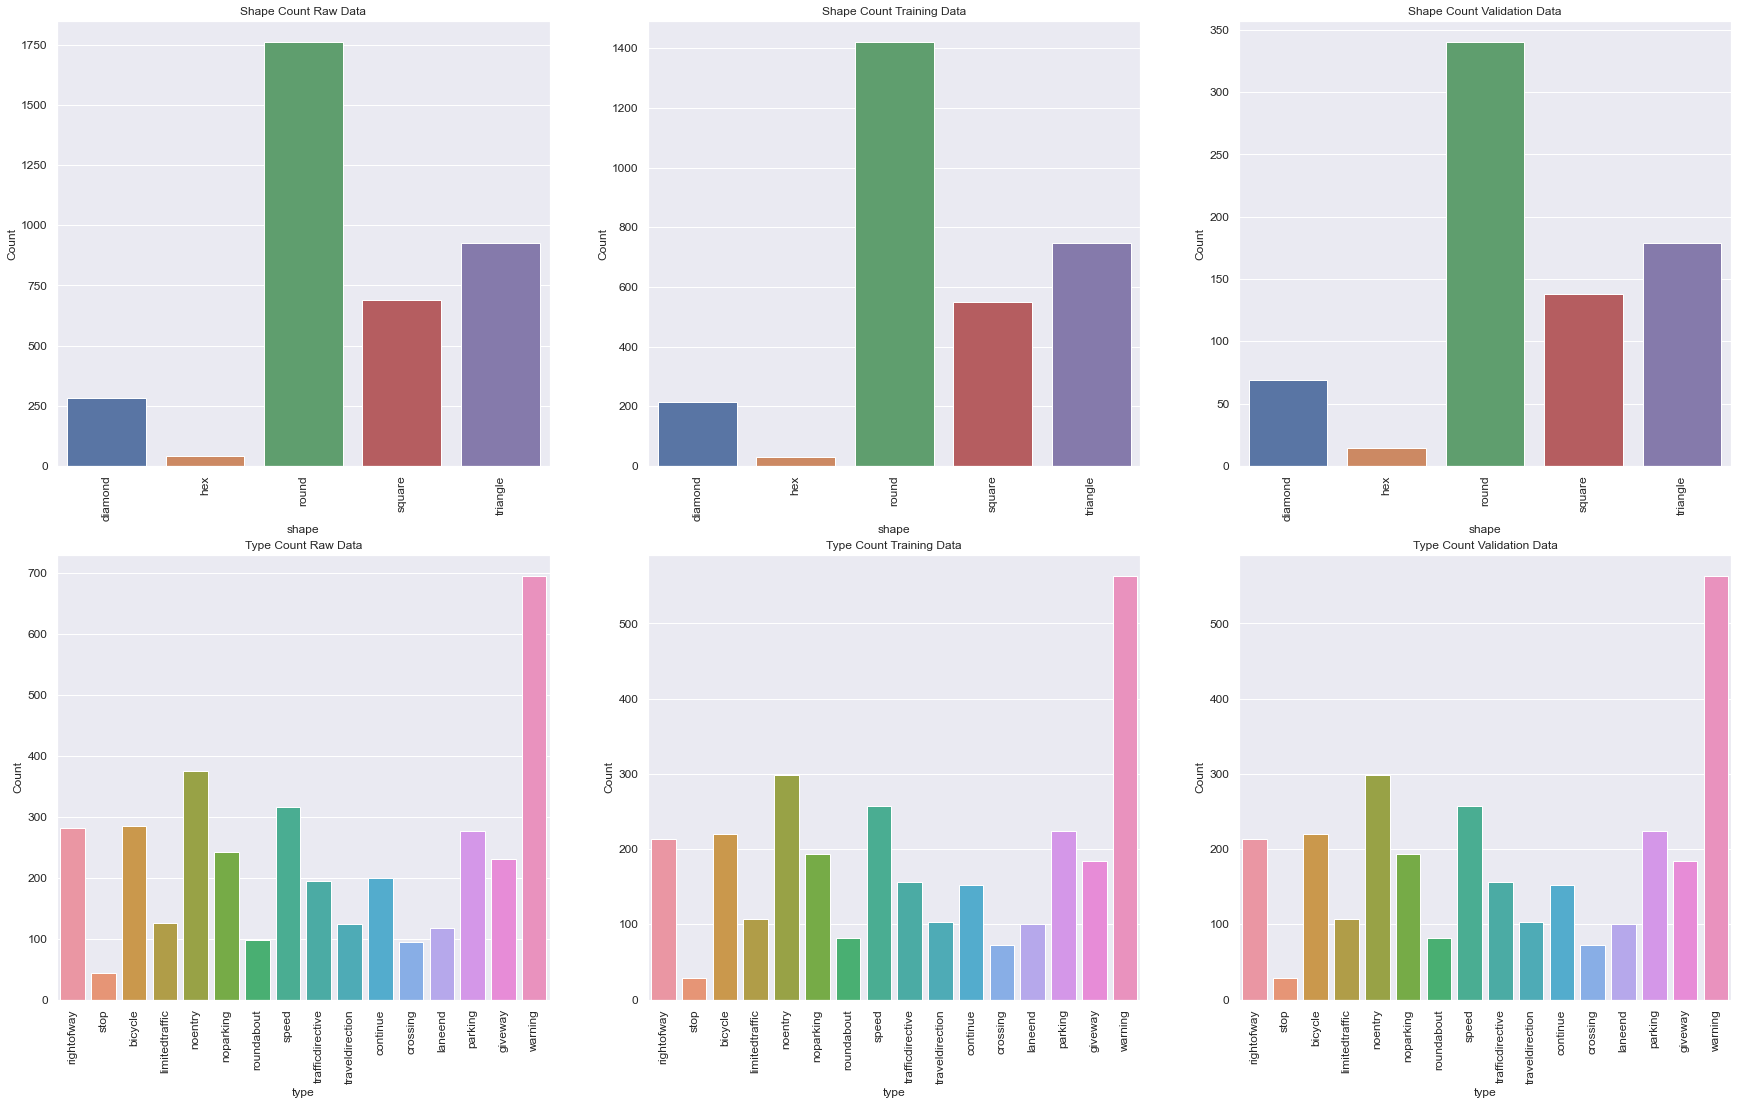

In [160]:
# Check Distribution of classes in training data splits compared to raw

sns.set_theme(style="darkgrid")

fig, ax = plt.subplots(2,3, figsize=(30,18))

make_subplot(x="shape",data=raw_data, order=SHAPE_NAMES, ax=ax[0,0], title="Shape Count Raw Data")
make_subplot(x="shape",data=shape_train_data, order=SHAPE_NAMES, ax=ax[0,1], title="Shape Count Training Data")
make_subplot(x="shape",data=shape_val_data, order=SHAPE_NAMES, ax=ax[0,2], title="Shape Count Validation Data")
make_subplot(x="type",data=raw_data, order=TYPE_NAMES, ax=ax[1,0], title="Type Count Raw Data")
make_subplot(x="type",data=type_train_data, order=TYPE_NAMES, ax=ax[1,1], title="Type Count Training Data")
make_subplot(x="type",data=type_train_data, order=TYPE_NAMES, ax=ax[1,2], title="Type Count Validation Data")


In [199]:
class CNNModel:

    def __init__(self):
        self.epochs = 5

    def create_data_generator(self, df,datagen,batch_size,target):
        generator = datagen.flow_from_dataframe(
            dataframe=df,
            directory = './',
            x_col='filepath',
            y_col=target,
            target_size=(28,28),
            batch_size=batch_size,
            class_mode='categorical'
        )

        return generator

    def build_vgg_model(self, num_classes):

        self.model = tf.keras.Sequential([
            #VGG block 1
            tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 3)),
            tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            
            #VGG block 2
            tf.keras.layers.Conv2D(56, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.Conv2D(56, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            
            #VGG block 3
            tf.keras.layers.Conv2D(112, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.Conv2D(112, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(112, activation='relu'),
            tf.keras.layers.Dense(num_classes),
        ])
    
    def compile_vgg_model(self):
        self.model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['categorical_accuracy'])
    
    def fit_model(self):
       return self.model.fit_generator(self.train_generator, validation_data=self.val_generator,\
           epochs=self.epochs,verbose=1)



In [200]:
shape_train_datagen = ImageDataGenerator(rescale=1.0/255, data_format='channels_last')
shape_val_datagen = ImageDataGenerator(rescale=1.0/255, data_format='channels_last')

type_train_datagen = ImageDataGenerator(rescale=1.0/255, data_format='channels_last')
type_val_datagen = ImageDataGenerator(rescale=1.0/255, data_format='channels_last')

# RESNET PAPER USED Batch Size 256. Batchsize to be updated later (Impact on Run Time)
vgg_batch_size = 32
resnet_batch_size = 256

vgg_shape_model = CNNModel()
vgg_type_model = CNNModel()
resnet_shape_model = CNNModel()
resnet_type_model = CNNModel()

# Baseline VGG Shape Model Data Generators
vgg_shape_model.train_generator = vgg_shape_model.create_data_generator(\
    shape_train_data,shape_train_datagen,vgg_batch_size,"shape")

vgg_shape_model.val_generator = vgg_shape_model.create_data_generator(\
    shape_val_data,shape_val_datagen,vgg_batch_size,"shape")

# Baseline VGG Type Model Data Generators
vgg_type_model.train_generator = vgg_type_model.create_data_generator(\
    type_train_data,type_train_datagen,vgg_batch_size,"type")

vgg_type_model.val_generator = vgg_type_model.create_data_generator(\
    type_val_data,type_val_datagen,vgg_batch_size,"type")

# Resnet Shape Model Data Generators
resnet_shape_model.train_generator = resnet_shape_model.create_data_generator(\
    shape_train_data,shape_train_datagen,resnet_batch_size,"shape")

resnet_shape_model.val_generator = resnet_shape_model.create_data_generator(\
    shape_val_data,shape_val_datagen,resnet_batch_size,"shape")

# Resnet Type Model Data Generators
resnet_type_model.train_generator = resnet_type_model.create_data_generator(\
    type_train_data,type_train_datagen,resnet_batch_size,"type")

resnet_type_model.val_generator = resnet_type_model.create_data_generator(\
    type_val_data,type_val_datagen,resnet_batch_size,"type")

Found 2959 validated image filenames belonging to 5 classes.
Found 740 validated image filenames belonging to 5 classes.
Found 2959 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.
Found 2959 validated image filenames belonging to 5 classes.
Found 740 validated image filenames belonging to 5 classes.
Found 2959 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.


In [201]:
# Build Model
vgg_shape_model.build_vgg_model(5)
vgg_type_model.build_vgg_model(16)

In [202]:
vgg_shape_model.compile_vgg_model()
vgg_type_model.compile_vgg_model()

vgg_shape_fit = vgg_shape_model.fit_model()
vgg_type_fit = vgg_type_model.fit_model()


Epoch 1/5


<ipython-input-199-0086be653b13>:48: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  return self.model.fit_generator(self.train_generator, validation_data=self.val_generator,\


93/93 [==============================] - 13s 129ms/step - loss: 0.9059 - categorical_accuracy: 0.6644 - val_loss: 0.4118 - val_categorical_accuracy: 0.9135
Epoch 2/5
93/93 [==============================] - 12s 132ms/step - loss: 0.1809 - categorical_accuracy: 0.9483 - val_loss: 0.1184 - val_categorical_accuracy: 0.9622
Epoch 3/5
93/93 [==============================] - 12s 133ms/step - loss: 0.0669 - categorical_accuracy: 0.9807 - val_loss: 0.0505 - val_categorical_accuracy: 0.9851
Epoch 4/5
93/93 [==============================] - 13s 138ms/step - loss: 0.0207 - categorical_accuracy: 0.9946 - val_loss: 0.0893 - val_categorical_accuracy: 0.9743
Epoch 5/5
93/93 [==============================] - 13s 140ms/step - loss: 0.0160 - categorical_accuracy: 0.9956 - val_loss: 0.0633 - val_categorical_accuracy: 0.9811
Epoch 1/5
93/93 [==============================] - 15s 135ms/step - loss: 1.7116 - categorical_accuracy: 0.4934 - val_loss: 0.6476 - val_categorical_accuracy: 0.8284
Epoch 2/5
93/9

In [203]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

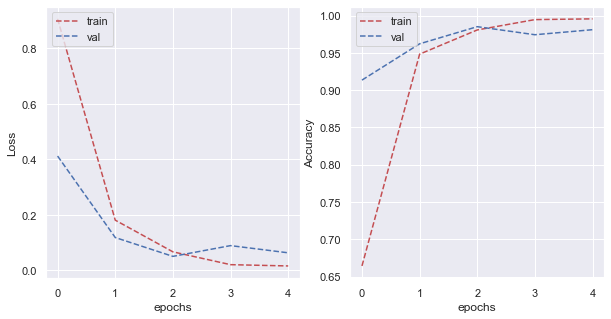

In [204]:
plot_learning_curve(vgg_shape_fit.history['loss'], vgg_shape_fit.history['val_loss'], 
                    vgg_shape_fit.history['categorical_accuracy'], vgg_shape_fit.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

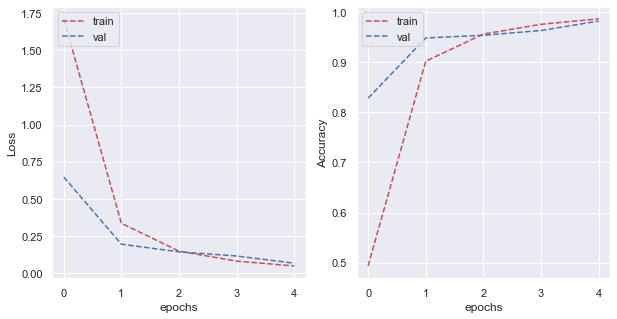

In [205]:
plot_learning_curve(vgg_type_fit.history['loss'], vgg_type_fit.history['val_loss'], 
                    vgg_type_fit.history['categorical_accuracy'], vgg_type_fit.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

# Modelling & Evaluation

### Baseline Model
VGG Baseline Model


From rubric:
* baseline model
* cost function
* optimisation


## Resnet Model
https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Networks_yourself.ipynb


In [ ]:
# identity block -> standard block used in ResNets 
def identity_block(X, f, filters, stage, block):
    '''
    identity blocks are required to transform into a residual network 
    inputs:
    X -> input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -> integer determining the shape of the middle CONV's window
    filters -> list of integers, defines number of filters in the CONV layer 
    stage -> integer, names the layers depending on position in NN
    block -> string, used to name the layers, depending on their position in the network

    outputs:
    X -> the identity block, tensor of shape (n_H, n_W, n_C)
    '''
    # defines the name of branch according to current position
    conv_name_base = "res" + str(stage) + block + "_branch"
    bn_name_base = "bn" + str(stage) + block + "_branch"

    # retrieve the filters to apply
    F1, F2, F3 = filters

    # save current input tensor
    X_save = X 

    # first component 
    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(1,1), padding="valid", name=conv_name_base+"2a", kernel_initializer=glorot_uniform(seed=0))(X)
    # normalises the channels axis
    X = BatchNormalization(axis=3, name=bn_name_base+"2a")(X)
    X = Activation("relu")(X)

    # second component
    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding="same", name=conv_name_base+"2b", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+"2b")(X)
    X = Activation("relu")(X)

    # third component
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding="valid", name=conv_name_base+"2c", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+"2c")(X)

    # add shorcut connection to main path 
    X = Add()([X, X_save])
    X = Activation("relu")(X)

    return X
    

In [161]:
# convolutional block -> standard block used in ResNets to ensure input and ouptut dimensions match
def convolutional_block(X, f, filters, stage, block, s=2):
    '''
    identity blocks are required to transform into a residual network 
    inputs:
    X -> input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -> integer determining the shape of the middle CONV's window
    filters -> list of integers, defines number of filters in the CONV layer 
    stage -> integer, names the layers depending on position in NN
    block -> string, used to name the layers, depending on their position in the network
    s -> integer, specifies the stride to be used, i.e. to reduce the dimension by a factor of 2, use a stride of 2

    outputs:
    X -> the identity block, tensor of shape (n_H, n_W, n_C)
    '''
    # defines the name of branch according to current position
    conv_name_base = "res" + str(stage) + block + "_branch"
    bn_name_base = "bn" + str(stage) + block + "_branch"

    # retrieve the filters to apply
    F1, F2, F3 = filters

    # to build shortcut path
    X_shortcut = X 

    # first component 
    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(s,s), padding="valid", name=conv_name_base+"2a", kernel_initializer=glorot_uniform(seed=0))(X)
    # normalises the channels axis
    X = BatchNormalization(axis=3, name=bn_name_base+"2a")(X)
    X = Activation("relu")(X)

    # second component
    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding="same", name=conv_name_base+"2b", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+"2b")(X)
    X = Activation("relu")(X)

    # third component
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding="valid", name=conv_name_base+"2c", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+"2c")(X)

    # build the shortcut path 
    X_shortcut = Conv2D(filters=F3, kernel_size=(1,1), strides=(s,s), padding="valid", name=conv_name_base+"1", kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base+"1")(X_shortcut)


    # add shortcut connection to main path 
    X = Add()([X, X_shortcut])
    X = Activation("relu")(X)

    return X

In [ ]:
# 50 layer ResNet Model
def ResNet50(input_shape=(64,64,3), classes=6):
    '''
    ResNet50 Architecture follows:
    (stage 1) = CONV2D -> BN -> RELU -> MAXPOOL -> 
    stage 2 = CONVBLOCK -> IDBLOCK x 2 -> 
    stage 3 = CONVBLOCK -> IDBLOCK X 3 -> 
    stage 4 = CONVBLOCK -> IDBLOCK X 5 -> 
    stage 5 = CONVBLOCK -> IDBLOCK x 2 -> 
    (stage 6) = AVGPOOL -> TOP LAYER

    inputs:
    input_shape -> shape of images in dataset 
    classes -> number of classes to predict

    outputs:
    model -> a Keras Model() instance for training
    '''
    # set the input shape
    X_input = Input(input_shape)

    # initialise the zero padding
    X = ZeroPadding2D((3,3))(X_input)

    # implement the architecture
    X = Conv2D(64, (7,7), strides=(2,2), name="conv1", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name="bn_conv1")(X)
    X = Activation("relu")(X)
    X = MaxPooling2D((3,3), strides(2,2))(X)

    X = convolutional_block(X, f=3, filters=[64,64,256], stage=2, block="a", s=1)
    X = identity_block(X, 3, [64,64,256], stage=2, block="b")
    X = identity_block(X, 3, [64,64,256], stage=2, block="c")

    X = convolutional_block(X, f=3, filters=[128,128,512], stage=3, block="a", s=2)
    X = identity_block(X, 3, [128,128,512], stage=3, block="b")
    X = identity_block(X, 3, [128,128,512], stage=3, block="c")
    X = identity_block(X, 3, [128,128,512], stage=3, block="d")

    X = convolutional_block(X, f=3, filters=[256,256,1024], stage=4, block="a", s=2)
    X = identity_block(X, 3, [256,256,1024], stage=4, block="b")
    X = identity_block(X, 3, [256,256,1024], stage=4, block="c")
    X = identity_block(X, 3, [256,256,1024], stage=4, block="d")
    X = identity_block(X, 3, [256,256,1024], stage=4, block="e")
    X = identity_block(X, 3, [256,256,1024], stage=4, block="f")

    X = convolutional_block(X, f=3, filters=[512,512,2048], stage=5, block="a", s=2)
    X = identity_block(X, 3, [512,512,2048], stage=5, block="b")
    X = identity_block(X, 3, [512,512,2048], stage=5, block="c")

    X = AveragePooling2D((7,7), name="avg_pool")(X)
    X = Flatten()(X)
    X = Dense(classes, activation="softmax", name="fc"+str(classes), kernel_initializer=glorot_uniform(seed=0))(X)

    # create the resnet model
    model = Model(inputs=X_input, outputs=X, name="ResNet50")

    return model

In [ ]:
# initialise the model
model = ResNet50(input_shape=(64,64,3), classes=6)

# compile the model
model.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=["categorical_accuracy"])

In [ ]:
# data in to model 
resnet_history = model.fit_generator(train_generator, validation_data=validation_generator)

In [ ]:
# get summary of model
model.summary()

In [ ]:
# results from training and val data 
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(resnet_history.history['loss'], 'r--')
plt.plot(resnet_history.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(resnet_history.history['categorical_accuracy'], 'r--')
plt.plot(resnet_history.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

## Ultimate Judgement - Sign-Shape

## Ultimate Judgement - Sign-Type

# Deployment on Independent Data

In [ ]:
# read in and prep of independent data

Can't forget:
* discuss challenges faced in combining new data to model 
    - data transformation into required format per training = 28x28 grey-scale etc.

# References
Kelleher, J., Namee, B. and D'Arcy, A., 2015. Fundamentals of Machine Learning for Predictive Data Analytics. Cambridge: MIT Press.
